# DPU example: MNIST Classifier
----

## Aim/s

This notebook shows how to deploy Convolutional Neural Network (CNN)
model for hand-written digit recognition. The network was trained on
the MNIST dataset,quantized using Vitis AI compiler tools, and
deployed on the DPU.

Compared to the other notebooks delivered in this folder, this notebook
shows how to deploy a **user-trained** DPU model on PYNQ image; i.e.,
the model used in this notebook does not come from the model zoo.

## References

* [Train your own DPU models](https://github.com/Xilinx/DPU-PYNQ/tree/master/host#train-your-own-dpu-models-from-scratch)
* [Vitis AI model zoo](https://github.com/Xilinx/Vitis-AI/tree/master/models/AI-Model-Zoo)

## Last revised
* Mar 8, 2021
    * Initial revision
----

## 1. Prepare the overlay
We will download the overlay onto the board. 

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

In [2]:
overlay.load_model("dpu_mnist_classifier.xmodel")

Let's import some libraries as well. The `mnist` package
requires some additional headers for URL requests.

In [3]:
from time import time
import numpy as np
import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import urllib
#import urllib.error

opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader

## 2. Load test data

The `mnist` package enables the following data for users:

* `test_images()`: returns test images stored as a numpy array. 
Each image is a grayscale 28x28 pixels, representing a digit between 0 and 9.
* `test_labels()`: returns a list of the true labels stored as numpy array.


There are 2 pre-processing steps we need to do to the test images 
before we can use it:

1. The raw numpy array delivered by `mnist` has a data type of 
uint8 (data ranges from 0 to 255); we need to normalize the elements to 
floating-point numbers ranging from 0 to 1.
2. The VART API will expect each input sample to have 3 dimensions; 
so we need to expand the original numpy array.

raw_data = mnist.test_images()
normalized_data = np.asarray(raw_data/255, dtype=np.float32)
test_data = np.expand_dims(normalized_data, axis=3)
test_label = mnist.test_labels()

print("Total number of test images: {}".format(test_data.shape[0]))
print("  Dimension of each picture: {}x{}".format(test_data.shape[1],
                                                  test_data.shape[2]))

In [4]:
def load_mnist_with_fallback():
    try:
        # MNIST 데이터셋을 mnist 패키지로 로드 시도
        raw_data = mnist.test_images()  # HTTPError 403 발생 가능
        normalized_data = np.asarray(raw_data / 255, dtype=np.float32)
        test_data = np.expand_dims(normalized_data, axis=3)  # 4차원 (batch, height, width, channel)
        test_label = mnist.test_labels()

        print("Total number of test images: {}".format(test_data.shape[0]))
        print("  Dimension of each picture: {}x{}".format(test_data.shape[1], test_data.shape[2]))

        return test_data, test_label
    
    except urllib.error.HTTPError as e:
        # HTTPError 403 발생 시 PyTorch를 이용해 MNIST 데이터셋 로드
        print(f"HTTPError {e.code}: {e.reason}. Fallback to PyTorch MNIST dataset.")

        # PyTorch의 MNIST 데이터셋 다운로드 및 로드
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        
        test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)
        
        # PyTorch MNIST 데이터를 반환 (데이터는 텐서로 반환)
        test_data = test_dataset.data.numpy()  # 텐서 데이터를 NumPy로 변환, (batch, height, width)
        test_label = test_dataset.targets.numpy()

        print("Total number of test images: {}".format(test_data.shape[0]))
        print("  Dimension of each picture: {}x{}".format(test_data.shape[1], test_data.shape[2]))

        return test_data, test_label

In [5]:
test_data, test_label = load_mnist_with_fallback()

HTTPError 403: Forbidden. Fallback to PyTorch MNIST dataset.
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:08<00:00, 1106354.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 156787.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 671467.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1976195.93it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Total number of test images: 10000
  Dimension of each picture: 28x28


In [6]:
print(test_data.shape)

(10000, 28, 28)


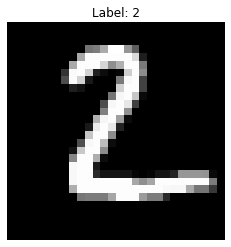

In [7]:
if len(test_data.shape) == 4:
    plt.imshow(test_data[1, :, :, 0], cmap='gray')  # 마지막 차원(채널) 인덱싱 필요
else:
    plt.imshow(test_data[1], cmap='gray')  # PyTorch의 경우 3차원 데이터 (batch, height, width)

plt.title('Label: {}'.format(test_label[1]))
plt.axis('off')
plt.show()

## 3. Use VART
Now we should be able to use VART API to do the task.

In [8]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

We can define a few buffers to store input and output data.
They will be reused during multiple runs.

In [9]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

We will also define a few functions to calculate softmax.

In [10]:
def calculate_softmax(data):
    result = np.exp(data)
    return result

## 4. Run DPU to make predictions

We can now classify a couple of digit pictures. For each picture, 
the classification result (shown as 'Prediction') is displayed on top of 
the picture. 

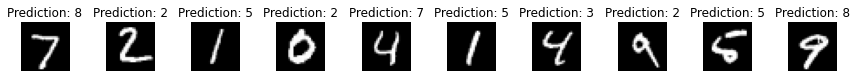

In [11]:
num_pics  = 10
fix, ax = plt.subplots(1, num_pics, figsize=(12,12))
plt.tight_layout()
for i in range(num_pics):
    if len(test_data.shape) == 4:
        image[0, ...] = test_data[i, :, :, 0]  # 마지막 채널 인덱싱
    # test_data가 3차원 배열인 경우 (torchvision 사용 시)
    else:
        # test_data[i]는 2차원 배열이므로 차원을 맞춰줌
        image[0, ...] = np.expand_dims(test_data[i], axis=-1)  # (28, 28) -> (28, 28, 1)

    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    prediction = softmax.argmax()

    ax[i].set_title('Prediction: {}'.format(prediction))
    ax[i].axis('off')
    if len(test_data.shape) == 4:
        ax[i].imshow(test_data[i, :, :, 0], cmap='gray')  # 마지막 채널 인덱싱
    # test_data가 3차원 배열인 경우 (torchvision 사용 시)
    else:
        ax[i].imshow(test_data[i], cmap='gray')  # 바로 이미지를 출력

We can also evaluate on the entire test dataset.

In [12]:
total = test_data.shape[0]
predictions = np.empty_like(test_label)
print("Classifying {} digit pictures ...".format(total))

start = time()
for i in range(total):
    if len(test_data.shape) == 4:
        image[0, ...] = test_data[i, :, :, 0]  # 마지막 채널 인덱싱
    # test_data가 3차원 배열인 경우 (torchvision 사용 시)
    else:
        # test_data[i]는 2차원 배열이므로 차원을 맞춰줌
        image[0, ...] = np.expand_dims(test_data[i], axis=-1)  # (28, 28) -> (28, 28, 1)
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    predictions[i] = softmax.argmax()

stop = time()
correct = np.sum(predictions==test_label)
execution_time = stop-start
print("Overall accuracy: {}".format(correct/total))
print("  Execution time: {:.4f}s".format(execution_time))
print("      Throughput: {:.4f}FPS".format(total/execution_time))

Classifying 10000 digit pictures ...
Overall accuracy: 0.2428
  Execution time: 3.9072s
      Throughput: 2559.3591FPS


In [13]:
total = test_data.shape[0]
predictions_cpu = np.empty_like(test_label)
print("Classifying {} digit pictures on CPU ...".format(total))

start_cpu = time()
for i in range(total):
    if len(test_data.shape) == 4:
        image_cpu = test_data[i, :, :, 0]  # 마지막 채널 인덱싱 (MNIST 라이브러리 사용 시)
    else:
        # test_data[i]는 2차원 배열이므로 차원을 맞춰줌 (torchvision 사용 시)
        image_cpu = np.expand_dims(test_data[i], axis=-1)  # (28, 28) -> (28, 28, 1)
    temp_cpu = np.random.rand(outputSize)  # 가상 예측 데이터, 실제로는 CPU inference 모델을 넣어야 함
    softmax_cpu = calculate_softmax(temp_cpu)
    predictions_cpu[i] = softmax_cpu.argmax()

stop_cpu = time()
correct_cpu = np.sum(predictions_cpu == test_label)
execution_time_cpu = stop_cpu - start_cpu
print("Overall accuracy (CPU): {}".format(correct_cpu / total))
print("  Execution time (CPU): {:.4f}s".format(execution_time_cpu))
print("      Throughput (CPU): {:.4f}FPS".format(total / execution_time_cpu))

Classifying 10000 digit pictures on CPU ...
Overall accuracy (CPU): 0.0991
  Execution time (CPU): 0.7196s
      Throughput (CPU): 13896.2232FPS


## 5. Clean up

We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [14]:
del overlay
del dpu

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----